In [179]:
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import glob
from sklearn.metrics import recall_score, confusion_matrix
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Loading Dataset

In [180]:
files = glob.glob('abolqasemi dataset/S*')
locs = sio.loadmat('abolqasemi dataset/cond.mat')['Cond'].reshape(-1)
mats = []
titles = []

for dir in files:
    s = sio.loadmat(dir)
    if len(s['su']) != 0:
        su = np.expand_dims(s['su'][0][0], axis=1)
        mats.append(su)
        titles.append(dir.split('\\')[-1])

# Preparing dataset

In [181]:
x = np.concatenate(mats, axis=1)[:,:,2500:5500]

# locations by angle
angles = locs.copy()
for i in range(8):
    angles[np.where(angles == i+9)] = i+1

# locations by radius
radiuses = locs.copy()
radiuses[np.where(radiuses < 9)] = 1
radiuses[np.where(radiuses > 8)] = 2


# SVM 

In [184]:
def SVM(x, y, num_trainings_per_win=200, win_len=50, stride=20):
    num_trainings_per_win = num_trainings_per_win
    win_len = win_len
    stride = stride
    num_wins = x.shape[-1]//stride

    recalls = np.zeros((num_trainings_per_win, len(set(y)), num_wins))
    confusion_mtrxs = np.zeros((num_trainings_per_win, num_wins, len(set(y)), len(set(y))))

    for n in tqdm(range(num_trainings_per_win)):
        for i, t in enumerate(np.arange(0, x.shape[-1], stride)):

            # averging the time window
            x_data = np.mean(x[:,:,t:t+win_len], 2)

            # train & test splitting
            x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.25, random_state=n)

            # standardizing dataset
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)

            # fitting model
            model = svm.SVC(kernel='linear')
            model.fit(x_train, y_train)

            # confusion matrixes
            y_pred = model.predict(x_test)
            cm = confusion_matrix(y_test, y_pred)
            confusion_mtrxs[n, i, :, :] = cm

            # recalls
            recall = recall_score(y_test, y_pred, average=None)
            recalls[n, :, i] = recall
    
    return model, recalls, confusion_mtrxs

## Locations by angle

In [190]:
model_angle, recalls_angle, confusion_mtrxs_angle = SVM(x, angles, num_trainings_per_win=200, win_len=50, stride=20)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [50:50<00:00, 15.25s/it]


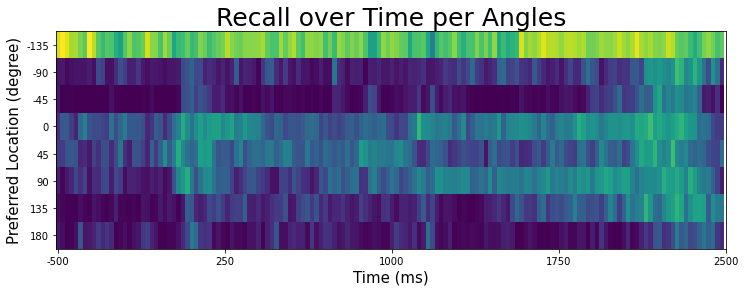

In [191]:
recalls_ag = np.mean(recalls_angle, 0)

plt.figure(figsize=(12,4))
plt.imshow(recalls_ag, cmap='viridis', aspect='auto')
plt.yticks(range(8), [-135, -90, -45, 0, 45, 90, 135, 180])
plt.xticks(np.linspace(0,150,5), np.linspace(-500,2500,5, dtype='int'))
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Preferred Location (degree)', fontsize=15)
plt.title('Recall over Time per Angles', fontsize=25)
plt.show()

## Locations by radius

In [186]:
model_radius, recalls_radius, confusion_mtrxs_radius = SVM(x, radiuses, num_trainings_per_win=200, win_len=50, stride=20)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [26:53<00:00,  8.07s/it]


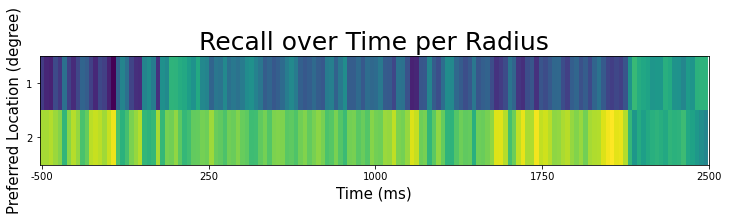

In [189]:
recalls_rs = np.mean(recalls_radius, 0)

plt.figure(figsize=(12,2))
plt.imshow(recalls_rs, cmap='viridis', aspect='auto')
plt.yticks(range(2), [1, 2])
plt.xticks(np.linspace(0,150,5), np.linspace(-500,2500,5, dtype='int'))
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Preferred Location (degree)', fontsize=15)
plt.title('Recall over Time per Radius', fontsize=25)
plt.show()

---
---
---